In [3]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import pandas as pd
import sys
sys.path.append('../LSP_Repo/')

import classifyFunctions
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, linear_model

# shap.initjs()

# corpus,y = shap.datasets.imdb()

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl')

classifyDict = dict()
classifyDict['data'] = 'count'
classifyDict['label'] = 'drug'
classifyDict['model'] = 'LogRegL1'
classifyDict['model_featureSel'] = 'L1'
classifyDict['model_classify'] = 'L2'
classifyDict['shuffle'] = True
classifyDict['includeSAL'] = True
classifyDict['include6FDET'] = True
classifyDict['remove_high_corr'] = True
classifyDict['corrThreshold'] = 0.8
classifyDict['gridCV'] = False


------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------ Fold Number: 5

------ Fold Number: 6

------ Fold Number: 7


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

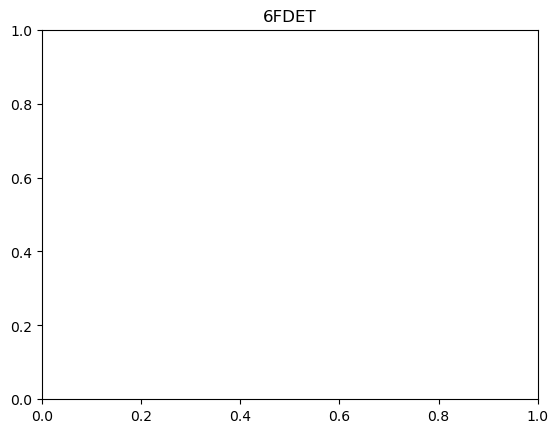

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

X, y, featureNames, numYDict = classifyFunctions.reformatData(lightsheet_data, classifyDict)

# corpus,y = shap.datasets.imdb()
vals2isolate = list(numYDict.keys())
shap_vals = [[] for _ in range(len(vals2isolate))]
SHAP_values_per_fold = []

np.random.seed(1) # Reproducibility 
CV_repeats = 10
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}

for idx in vals2isolate:

    Z = idx
    yBinary = y.copy()
    yBinary[y != Z] = 0
    yBinary[y == Z] = 1
    skf = StratifiedKFold(n_splits=8)  # 8 examples of each label
    ix_training, ix_test = [], []

    # For the sake of capturing all indices prior to looping
    for train_index, test_index in skf.split(X, yBinary):
        ix_training.append(train_index), ix_test.append(test_index)

    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): #-#-#
    # for train_index, test_index in skf.split(X, yBinary):

        # X_train, X_test, y_train, y_test = train_test_split(X, yBinary, test_size=1/8, random_state=7)

        # Grab training data and test data
        print('\n------ Fold Number:',i)
        X_train, X_test = X[train_outer_ix], X[test_outer_ix]
        y_train, y_test = yBinary[train_outer_ix], yBinary[test_outer_ix]

        model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1, solver="lbfgs") #multi_class="ovr"
        pipeline = make_pipeline(preprocessing.RobustScaler(), model)
        pipelineT = make_pipeline(preprocessing.RobustScaler())
        pipelineT.fit(X_train, y_train)
        pipeline.fit(X_train, y_train)

        X_train_trans = pipelineT.transform(X_train)

        explainer = shap.Explainer(pipeline._final_estimator, X_train_trans, feature_names=featureNames, max_iter=1000)
        shap_values = explainer(X_test)
        
        for SHAPs in shap_values:
            SHAP_values_per_fold.append(SHAPs)

    new_index = [ix for ix_test_fold in ix_test for ix in ix_test_fold]
    plt.title(numYDict[idx])
    new_idx = np.array(new_index).reshape(-1, 1)
    resorted_X = X[new_idx,:]
    shap.summary_plot(np.array(SHAP_values_per_fold), resorted_X)
    # shap.plots.beeswarm(np.array(SHAP_values_per_fold))
        
    # shap.plots.beeswarm(shap_values, link=shap.links.logit, max_display=10, order=shap_values.abs.max(0))


In [ ]:
ind = 0
shap.plots.force(shap_values[ind])

